# ZFOURGE Observational Modelling and Fitting Analysis
This section is dedicated entirely to outputing the results from the ZFOURGE survey observational fitting, including creation of composite SED data. This involves some rudimentary fitting/analysis but nothing major. 

In [36]:
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits
from carf import * # custom module for functions relating to the project
import matplotlib.path as mpath
import seaborn as sns
from scipy.stats import gaussian_kde

# So that we can change the helper functions without reloading the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# Choose if you want to save the plots
save_figures = True
fig_size_params = (7, 5)

In [38]:
# We would like to investigate the effects of the different filters.
# Read in the dataframe

#field = 'COSMOS'
agn_model_name = 'Type1AGN'
template_set_name = 'ZFOURGE'

# read in the dataframe and ensure that the unamed: 0 column is the index
composite_choice = f'ZFOURGE_obsevational_composites_fluxes{agn_model_name}'
composite_fluxes = pd.read_csv(f'outputs\composite_seds\{composite_choice}.csv', index_col=0)   
# Drop the first col
#composite_fluxes = composite_fluxes.drop(columns=['Unnamed: 0.1'])

composite_fluxes.reset_index(drop=True, inplace=True)

In [39]:
# Check outputs
composite_fluxes

# Check index column 
len(composite_fluxes.index.unique())

11449

In [40]:
composite_fluxes['id'].duplicated().sum()

# drop the duplicates
composite_fluxes = composite_fluxes.drop_duplicates(subset='id')


In [41]:
# have a look at it now
composite_fluxes


,id,z,U_0,U_10,U_20,U_30,U_40,U_50,U_60,U_70,...,r_20,r_30,r_40,r_50,r_60,r_70,r_80,r_90,r_100,field
0,COSMOS_10007,1.2066,-21.752929,-21.789159,-21.824219,-21.858182,-21.891115,-21.923078,-21.954127,-21.984313,...,22.120946,22.084294,22.048838,22.014504,21.981223,21.948931,21.917572,21.887094,21.857448,COSMOS
1,COSMOS_10010,0.9092,-23.024490,-23.068547,-23.110885,-23.151633,-23.190908,-23.228811,-23.265436,-23.300865,...,20.247843,20.199976,20.154131,20.110144,20.067869,20.027179,19.987959,19.950107,19.913529,COSMOS
2,COSMOS_10014,1.4606,-20.165845,-20.201876,-20.236750,-20.270539,-20.303307,-20.335116,-20.366019,-20.396067,...,24.091096,24.056942,24.023830,23.991698,23.960489,23.930153,23.900641,23.871910,23.843920,COSMOS
3,COSMOS_10021,0.4359,-24.826367,-24.875311,-24.922143,-24.967039,-25.010152,-25.051618,-25.091558,-25.130081,...,15.965769,15.937468,15.909886,15.882987,15.856738,15.831109,15.806071,15.781598,15.757664,COSMOS
4,COSMOS_10023,3.3215,-18.663227,-18.696958,-18.729672,-18.761429,-18.792283,-18.822285,-18.851480,-18.879911,...,27.311427,27.283895,27.257043,27.230840,27.205254,27.180257,27.155823,27.131927,27.108545,COSMOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11444,CDFS_9974,0.7378,-21.028655,-21.092845,-21.153452,-21.210853,-21.265372,-21.317283,-21.366826,-21.414205,...,21.390317,21.339278,21.290531,21.243878,21.199148,21.156188,21.114863,21.075054,21.036652,CDFS
11445,CDFS_9975,2.1548,-18.290457,-18.323979,-18.356498,-18.388070,-18.418751,-18.448588,-18.477627,-18.505910,...,26.711340,26.684006,26.657343,26.631320,26.605905,26.581072,26.556794,26.533047,26.509809,CDFS
11446,CDFS_9978,3.2821,-18.011666,-18.043725,-18.074865,-18.105137,-18.134587,-18.163260,-18.191195,-18.218429,...,27.936887,27.910722,27.885174,27.860213,27.835812,27.811949,27.788598,27.765739,27.743351,CDFS
11447,CDFS_9983,1.8737,-18.980504,-19.018434,-19.055085,-19.090538,-19.124871,-19.158151,-19.190441,-19.221798,...,26.173512,26.125943,26.080370,26.036634,25.994591,25.954116,25.915095,25.877429,25.841025,CDFS


In [42]:
# Make some plots
# Plot the SEDs of the composite object
# Get the filters
filters = composite_fluxes.columns[2:]

# For the first filter, see how many variations there are
filter_choice = filters[0].split('_')[0]


# Get the variations
filter_variations = [filter for filter in filters if filter_choice in filter]

# add the alpha values to a new array
alpha_values = [int(filter.split('_')[1]) for filter in filter_variations]

# Print the alpha values
print(alpha_values)

spacing = len(alpha_values)
colours_theme = plt.cm.viridis(np.linspace(0, 1, spacing))

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


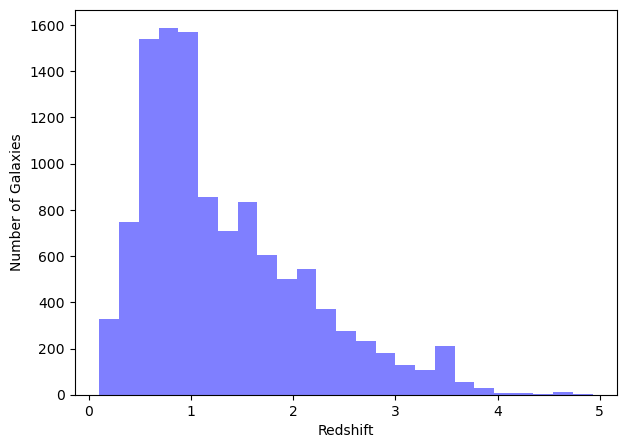

In [43]:
# Check the range of redshift values
composite_fluxes['z'].describe()


# Plot the redshifts of the zfourge sample
plt.figure(figsize=fig_size_params)
plt.hist(composite_fluxes['z'], bins=25, color='blue', alpha=0.5)
plt.xlabel('Redshift')
plt.ylabel('Number of Galaxies')
#plt.title('Redshift distribution of the ZFOURGE sample')
# Save the output 
if save_figures:
    plt.savefig(f'outputs\ThesisPlots\{composite_choice}_redshift_distribution.png')
    

plt.show()


In [44]:
# Read in zfourge.csv from the outputs folder
zfourge = pd.read_csv('outputs\zfourge.csv', index_col=0)

zfourge

C:\Users\Titan\AppData\Local\Temp\ipykernel_35220\3571392759.py:2: DtypeWarning: Columns (156) have mixed types. Specify dtype option on import or set low_memory=False.
  zfourge = pd.read_csv('outputs\zfourge.csv', index_col=0)


,id,xpos,ypos,RAJ2000,DEJ2000,SE,isoArea,FKsap,e_FKsap,apcorr,...,FH,e_FH,w_FH,FK,e_FK,w_FK,FY,e_FY,w_FY,wminAll
recno,,,,,,,,,,,,,,,,,,,,,
5746,CDFS_5746,4778.412,2191.809,53.067131,-27.883856,2,362.0,2.69849,0.09566,1.031906,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5860,CDFS_5860,4916.620,2228.198,53.060615,-27.882338,3,247.0,8.31529,0.10266,1.075718,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5864,CDFS_5864,4866.185,2207.664,53.062992,-27.883194,3,187.0,9.18890,0.09829,1.101090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5880,CDFS_5880,4918.070,2205.127,53.060547,-27.883299,3,134.0,3.12787,0.10767,1.095818,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5886,CDFS_5886,4903.505,2218.433,53.061234,-27.882744,3,182.0,3.09289,0.10266,1.072291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22083,UDS_22083,2302.426,4849.815,34.332954,-5.114601,0,62.0,1.18976,0.07315,1.159828,...,2.59206,0.30675,1.0,2.82203,0.20118,0.90,NaN,NaN,0.0,0.78
22086,UDS_22086,4080.163,4739.570,34.258579,-5.119182,0,130.0,2.54756,0.06966,1.093092,...,6.33329,0.34497,1.0,6.28376,0.20835,1.06,NaN,NaN,0.0,0.86
22087,UDS_22087,1714.118,4854.707,34.357567,-5.114399,0,20.0,0.42294,0.07834,1.469092,...,0.51570,0.28064,1.0,0.53615,0.19981,0.77,NaN,NaN,0.0,0.68


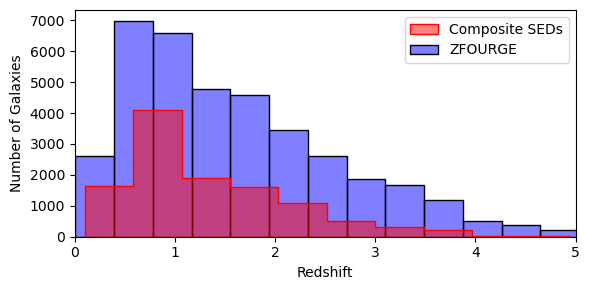

In [45]:
# plot a histogram of the redshifts
plt.figure(figsize=(6, 3))
sns.histplot(zfourge['zpk'], bins=25, color='blue', alpha=0.5)
plt.xlabel('Redshift')
plt.ylabel('Number of Galaxies')
#plt.title('Redshift distribution of the ZFOURGE sample')

# overlay the composite fluxes
sns.histplot(composite_fluxes['z'], bins=10, color='red', alpha=0.5, fill=True, element='step')
plt.xlabel('Redshift')
plt.ylabel('Number of Galaxies')
#plt.title('Redshift distribution of the ZFOURGE sample')

# instead, just use a line overlay to
plt.legend(['Composite SEDs', 'ZFOURGE'])
# Change lims
plt.xlim(0, 5)
plt.tight_layout()
# Save the output
if save_figures:
    plt.savefig(f'outputs\ThesisPlots\{composite_choice}_redshift_distribution.png', dpi=300)
    

plt.show()


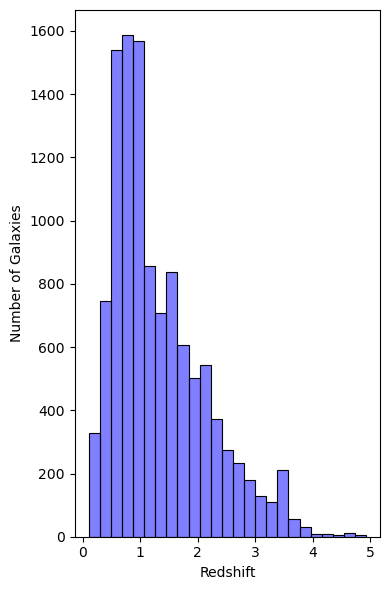

In [46]:
# Use seaborn instead

plt.figure(figsize=(4, 6))
sns.histplot(composite_fluxes['z'], bins=25, color='blue', alpha=0.5)
plt.xlabel('Redshift')
plt.ylabel('Number of Galaxies')
#plt.title('Redshift distribution of the ZFOURGE sample')
# Save the output
if save_figures:
    plt.tight_layout()
    plt.savefig(f'outputs\ThesisPlots\{composite_choice}_redshift_distribution_seaborn.png', dpi=300)
    
plt.show()




In [47]:

from scipy.stats import skew
# Print summary statistics for the redshift distribution
data = composite_fluxes['z']


# Calculate descriptive statistics
mean = np.mean(data)
median = np.median(data)
mode = np.argmax(np.bincount(np.round(data).astype(int))) # Mode for continuous data
std_dev = np.std(data)
skewness = skew(data)
percentiles = np.percentile(data, [10, 25, 50, 75, 90])
iqr = percentiles[3] - percentiles[1]

# Print results
print(f"Mean: {mean:.2f}")
print(f"Median: {median:.2f}")
print(f"Mode: {mode:.2f}")
print(f"Standard Deviation: {std_dev:.2f}")
print(f"Skewness: {skewness:.2f}")
print(f"10th Percentile: {percentiles[0]:.2f}")
print(f"25th Percentile (Q1): {percentiles[1]:.2f}")
print(f"50th Percentile (Median): {percentiles[2]:.2f}")
print(f"75th Percentile (Q3): {percentiles[3]:.2f}")
print(f"90th Percentile: {percentiles[4]:.2f}")
print(f"Interquartile Range (IQR): {iqr:.2f}")

Mean: 1.32
Median: 1.06
Mode: 1.00
Standard Deviation: 0.82
Skewness: 1.09
10th Percentile: 0.51
25th Percentile (Q1): 0.71
50th Percentile (Median): 1.06
75th Percentile (Q3): 1.77
90th Percentile: 2.48
Interquartile Range (IQR): 1.06


## UVJ

11449
redshift_bin:  [0, 5]


C:\Users\Titan\AppData\Local\Temp\ipykernel_35220\924230192.py:148: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


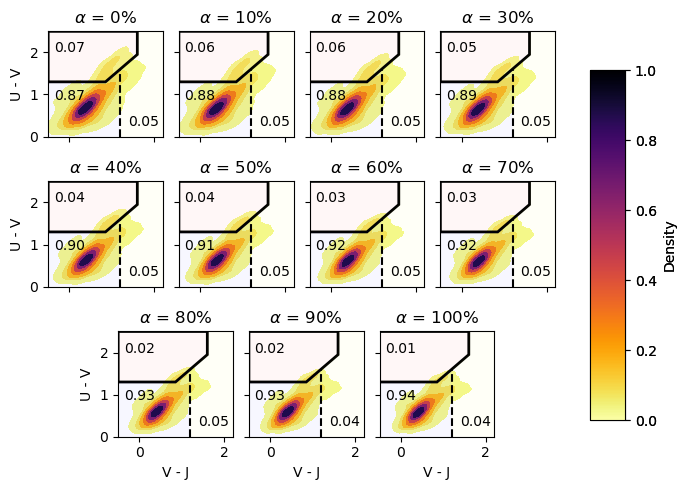

In [48]:
spacing = len(alpha_values)
#colours_theme = plt.cm.viridis(np.linspace(0, 1, spacing))
# # Galaxy Fractions - Quiescent, Star-forming, Dusty for each alpha value
galaxy_fractions = {'Star-forming': [], 'Quiescent': [], 'Dusty': []} # each key will have a list of fractions for each alpha value
num_galaxies = len(composite_fluxes) # number of galaxies in the composite_flux in the rest frame

print(num_galaxies)

redshift_bins = [[0, 0.5], [0.5, 1], [1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 3.5], [3.5, 4], [4, 4.5], [4.5, 5]]

# For a single redshift bin output, change the bins 
redshift_bins = [[0, 5]]
kde_colour = []
for redshift_bin in redshift_bins:
    lower_redshift_limit = redshift_bin[0]
    upper_redshift_limit = redshift_bin[1]

    subset_composite_fluxes = composite_fluxes[(composite_fluxes['z'] >= lower_redshift_limit) & (composite_fluxes['z'] < upper_redshift_limit)].copy()

    print("redshift_bin: ", redshift_bin)


    fig, axs = plt.subplots(3, 4, figsize=fig_size_params, sharex=True, sharey=True)
    

    for n in range(len(alpha_values)):
        # Get the filter magnitudes
        U_mag = subset_composite_fluxes[f'U_{alpha_values[n]}']
        V_mag = subset_composite_fluxes[f'V_{alpha_values[n]}']
        J_mag = subset_composite_fluxes[f'J_{alpha_values[n]}']
        
        # Create the colours
        uv = U_mag - V_mag
        vj = V_mag - J_mag
        
        # If the uv, and vj values don't exsist in this redshift bin, skip this bin
        if len(uv) == 0:
            break
        
        
       
        
        axs[n//4, n%4].set_xlim(-0.5, 2.2)
        axs[n//4, n%4].set_ylim(0, 2.5)
        
        # Plot AGN Contribution in the title 
        # alpha needs to be the alpha symbol
        #alpha_symbol = r'$\alpha$'
        axs[n//4, n%4].set_title(rf'$\alpha$ = {alpha_values[n]}%')
        
        # Define paths for selections
        path_quiescent = [[-0.5, 1.3], [0.85, 1.3], [1.6, 1.95], [1.6, 2.5], [-0.5, 2.5]]
        path_sf = [[-0.5, 0.0], [-0.5, 1.3], [0.85, 1.3], [1.2, 1.60333], [1.2, 0.0]]
        path_sfd = [[1.2, 0.0], [1.2, 1.60333], [1.6, 1.95], [1.6, 2.5], [2.2, 2.5], [2.2, 0.0]]
         
        # We will obtain the Star-forming, Quiescent, and Dusty Fractions for this particular alpha value     
        # Obtain the number of galaxies with sf region dictated by the sf path
        # Create Path objects from your path coordinates (do this once, outside the loop)
        path_quiescent_obj = mpath.Path(path_quiescent)
        path_sf_obj = mpath.Path(path_sf)
        path_sfd_obj = mpath.Path(path_sfd)

        # Create a DataFrame with just the uv and vj columns for easier selection
        uvj_data = pd.DataFrame({'V - J': vj, 'U - V': uv})

        
        
        
       
        
         #axs[n//4, n%4].scatter(vj, uv, c='blue', s=10)
        # Plot KDE
        #kde_plot = sns.kdeplot(data=uvj_data, x='V - J', y='U - V', ax=axs[n//4, n%4], fill=True, cmap='flare', levels=8)
        
        if n >= 0:
            kde_plot = sns.kdeplot(data=uvj_data, x='V - J', y='U - V', ax=axs[n//4, n%4], fill=True, cmap='inferno_r', levels=8)
            kde_colour.append(kde_plot)
        
        # Add patches for selections
        axs[n//4, n%4].add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
        axs[n//4, n%4].add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
        axs[n//4, n%4].add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))
        
        # Add vertical line
        axs[n//4, n%4].axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)
        
        # Add axis labels
        if n//4 == 2:
            axs[n//4, n%4].set_xlabel("V - J")
        if n%4 == 0:
            axs[n//4, n%4].set_ylabel("U - V")
            
            
    # Perform the selection
        quiescent_seds = uvj_data[path_quiescent_obj.contains_points(uvj_data.values)]
        sf_seds = uvj_data[path_sf_obj.contains_points(uvj_data.values)]
        sfd_seds = uvj_data[path_sfd_obj.contains_points(uvj_data.values)]
        
        # Calculate the fractions
        quiescent_fraction = len(quiescent_seds)/num_galaxies
        sf_fraction = len(sf_seds)/num_galaxies
        sfd_fraction = len(sfd_seds)/num_galaxies
        
        # Append the fractions to the dictionary
        galaxy_fractions['Quiescent'].append(quiescent_fraction)
        galaxy_fractions['Star-forming'].append(sf_fraction)
        galaxy_fractions['Dusty'].append(sfd_fraction)
       
         # Plot the fractions in the corner of each section on the UVJ
        axs[n//4, n%4].text(0.05, 0.8, f'{quiescent_fraction:.2f}', transform=axs[n//4, n%4].transAxes, color='k')
        axs[n//4, n%4].text(0.05, 0.35, f'{sf_fraction:.2f}', transform=axs[n//4, n%4].transAxes, color='k')
        axs[n//4, n%4].text(0.70, 0.1, f'{sfd_fraction:.2f}', transform=axs[n//4, n%4].transAxes, color='k')
        
        
        
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    sm = plt.cm.ScalarMappable(cmap=plt.cm.inferno_r, norm=plt.Normalize(vmin=0, vmax=1))
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Density')

        
        
    # axs[2, 3].plot(alpha_values, galaxy_fractions['Quiescent'], label='Quiescent', color='red')
    # axs[2, 3].plot(alpha_values, galaxy_fractions['Star-forming'], label='Star-forming', color='blue')
    # axs[2, 3].plot(alpha_values, galaxy_fractions['Dusty'], label='Dusty', color='Green')

    # # Add labels
    # axs[2, 3].set_xlabel(f'AGN Contribution (%)')
    # axs[2, 3].set_ylabel('Fraction')
    #ax.set_title('Fraction of Galaxies in UVJ Diagram')
    #axs[2, 3].legend()     
    
    # Ensure that the axis is not shared for this final plot

    
    # Show a single colorbar for the entire plot, showing the change in KDE
    
    
     # Make the subplots closer together
    #plt.subplots_adjust(wspace=0.5, hspace=0.6)
    
    # Remove the first axis label, for the first subplot
    axs[0, 0].set_xlabel('')
    
    
    # 
    plt.tight_layout()
    
    
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    sm = plt.cm.ScalarMappable(cmap=plt.cm.inferno_r, norm=plt.Normalize(vmin=0, vmax=1))
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Density')


    pos = axs[2, 0].get_position()
    newpos = [pos.x0 + 0.1, pos.y0, pos.width, pos.height] 
    axs[2,0].set_position(newpos)
    
    pos = axs[2, 1].get_position()
    newpos = [pos.x0 + 0.1, pos.y0, pos.width, pos.height] 
    axs[2,1].set_position(newpos)
    
    pos = axs[2, 2].get_position()
    newpos = [pos.x0 + 0.1, pos.y0, pos.width, pos.height] 
    axs[2,2].set_position(newpos)
    
    # Remove 2, 3
    fig.delaxes(axs[2, 3])
    
    
    # Save the output
    if save_figures:
        plt.savefig(f'outputs/ThesisPlots/UVJ_evolution_{agn_model_name}_ZFOURGE_{lower_redshift_limit}_{upper_redshift_limit}.png', dpi=300)

    # Show the output
    plt.show()


In [49]:
# # Do the same as above but bin the redshifts instead of the alpha vals
# redshift_bins = [[0, 0.5], [0.5, 1], [1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 3.5], [3.5, 4], [4, 4.5], [4.5, 5]]


# average_redshift_colours = {'uv': [], 'vj': []}

# # For a single redshift bin output, change the bins 
# #redshift_bins = [[0, 5]]
# fig, axs = plt.subplots(3, 4, figsize=fig_size_params, sharex=True, sharey=True)
# for n, redshift_bin in enumerate(redshift_bins):
#     lower_redshift_limit = redshift_bin[0]
#     upper_redshift_limit = redshift_bin[1]

#     subset_composite_fluxes = composite_fluxes[(composite_fluxes['z'] >= lower_redshift_limit) & (composite_fluxes['z'] < upper_redshift_limit)].copy()

#     print("redshift_bin: ", redshift_bin)



#     for m in range(len(alpha_values)):
#         # Get the filter magnitudes
#         U_mag = subset_composite_fluxes[f'U_{alpha_values[m]}']
#         V_mag = subset_composite_fluxes[f'V_{alpha_values[m]}']
#         J_mag = subset_composite_fluxes [f'J_{alpha_values[m]}']
        
#         # Create the colours
#         uv = U_mag - V_mag
#         vj = V_mag - J_mag
        
#         # Add the uv and vj values to the average_redshift_colours dictionary
#         # only for the 100 AGN contribution
#         if alpha_values[m] == 100:
#             average_redshift_colours['uv'].append(np.mean(uv))
#             average_redshift_colours['vj'].append(np.mean(vj))
        

#         # Plot scatter
#         axs[n//4, n%4].scatter(vj, uv, c=[colour_theme[m]], s=10)
        
        
#         # Add axis labels
#         if n//4 == 2:
#             axs[n//4, n%4].set_xlabel("V - J")
#         if n%4 == 0:
#             axs[n//4, n%4].set_ylabel("U - V")
            
        
        
        
#         # We will obtain the Star-forming, Quiescent, and Dusty Fractions for this particular alpha value     
#         # Obtain the number of galaxies with sf region dictated by the sf path
#         # Create Path objects from your path coordinates (do this once, outside the loop)
#         path_quiescent_obj = mpath.Path(path_quiescent)
#         path_sf_obj = mpath.Path(path_sf)
#         path_sfd_obj = mpath.Path(path_sfd)

#         # Create a DataFrame with just the uv and vj columns for easier selection
#         uvj_data = pd.DataFrame({'vj': vj, 'uv': uv})

#         # Perform the selection
#         quiescent_seds = uvj_data[path_quiescent_obj.contains_points(uvj_data.values)]
#         sf_seds = uvj_data[path_sf_obj.contains_points(uvj_data.values)]
#         sfd_seds = uvj_data[path_sfd_obj.contains_points(uvj_data.values)]
        
#         # Add patches for selections
#     axs[n//4, n%4].add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
#     axs[n//4, n%4].add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
#     axs[n//4, n%4].add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

#     # Add vertical line
#     axs[n//4, n%4].axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)

#     # Add axis labels
#     axs[n//4, n%4].set_xlabel("V - J")

#     # AGN Colour Evolution title - just call it redshift
#     axs[n//4, n%4].set_title(f"{lower_redshift_limit} < z < {upper_redshift_limit}")
    
#     # Ensure limits
#     axs[n//4, n%4].set_xlim(-0.5, 2.2)
#     axs[n//4, n%4].set_ylim(0, 2.5)
    

#     # # Plot colorbar for AGN contribution
#     # sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
#     # cbar = plt.colorbar(sm, ax=axs[n//4, n%4])

#     # # Name the colorbar
#     # cbar.set_label('AGN Contribution')

#     # Plot one colourbar down the bottom where the other subplots should have been
#     if n == len(redshift_bins) - 1:
#         sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
#         cbar = plt.colorbar(sm, ax=axs[n//4, n%4])

#         # Name the colorbar
#         cbar.set_label('AGN Contribution')
        
        
#     # for m in range(len(alpha_values)):
#     #     # Get the filter magnitudes
#     #     U_mag = subset_composite_fluxes[f'U_{alpha_values[m]}']
#     #     V_mag = subset_composite_fluxes[f'V_{alpha_values[m]}']
#     #     J_mag = subset_composite_fluxes [f'J_{alpha_values[m]}']
        
#     #     # Create the colours
#     #     uv = U_mag - V_mag
#     #     vj = V_mag - J_mag
        

#     #     # Plot scatter
#     #     axs[2, 3].scatter(vj, uv, c=[colours_theme[m]], s=10)
    
#     # In the last subplot axs 2, 2 
#     # calc the average position of the final uv vj colours (at AGN contribution 100) and plot it's progression in colour space
    
    
    
# # Create the colours
# uv = average_redshift_colours['uv']
# vj = average_redshift_colours['vj']

# # Create the redshift bins
# redshift_bins = np.array(redshift_bins)
# colors = np.linspace(0, 1, len(redshift_bins))


# # Plot scatter
# axs[2, 2].scatter(vj, uv, c=colors, s=10)

# #  Set 

# # Add patches for selections
# axs[2, 2].add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
# axs[2, 2].add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
# axs[2, 2].add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

# # Add vertical line
# axs[2, 2].axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)

# # Add axis labels
# axs[2, 2].set_xlabel("V - J")

# # AGN Colour Evolution title
# axs[2, 2].set_title("Redshift Evolution for \n AGN Contribution = 100%")

# # Plot colorbar for AGN contribution
# sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=5))
# cbar = plt.colorbar(sm, ax=axs[2, 2])

    
        
    

            
#         # Make the subplots closer together
# # plt.subplots_adjust(wspace=0.05, hspace=0.3)
# plt.tight_layout()

# # Delete the last two subplots
# fig.delaxes(axs[2, 3])


# # Save 
# if save_figures:
#     plt.savefig(f'outputs/ThesisPlots/UVJ_redshift_agn_evolution_{agn_model_name}_ZFOURGE.png')

# plt.show()



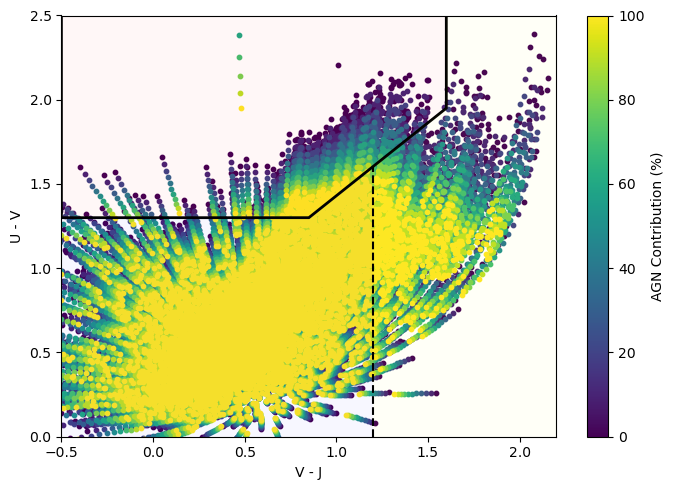

In [50]:
# Maybe just plot an all redshift UVJ diagram 
fig, axs = plt.subplots(1, 1, figsize=fig_size_params, sharex=True, sharey=True)

# Reset the galaxy fractions
galaxy_fractions = {'Star-forming': [], 'Quiescent': [], 'Dusty': []} # each key will have a list of fractions for each alpha value
num_galaxies = len(composite_fluxes) # number of galaxies in the composite_flux in the rest frame



for m in range(len(alpha_values)):
    # Get the filter magnitudes
    U_mag = composite_fluxes[f'U_{alpha_values[m]}']
    V_mag = composite_fluxes[f'V_{alpha_values[m]}']
    J_mag = composite_fluxes[f'J_{alpha_values[m]}']
    
    # Create the colours
    uv = U_mag - V_mag
    vj = V_mag - J_mag
    
    # Add the uv and vj values to the average_redshift_colours dictionary
    # only for the 100 AGN contribution

    # Plot scatter
    axs.scatter(vj, uv, c=[colours_theme[m]], s=10)
    

        
    
    
    
    # We will obtain the Star-forming, Quiescent, and Dusty Fractions for this particular alpha value     
    # Obtain the number of galaxies with sf region dictated by the sf path
    # Create Path objects from your path coordinates (do this once, outside the loop)
    path_quiescent_obj = mpath.Path(path_quiescent)
    path_sf_obj = mpath.Path(path_sf)
    path_sfd_obj = mpath.Path(path_sfd)

    # Create a DataFrame with just the uv and vj columns for easier selection
    uvj_data = pd.DataFrame({'vj': vj, 'uv': uv})

    # Perform the selection
    quiescent_seds = uvj_data[path_quiescent_obj.contains_points(uvj_data.values)]
    sf_seds = uvj_data[path_sf_obj.contains_points(uvj_data.values)]
    sfd_seds = uvj_data[path_sfd_obj.contains_points(uvj_data.values)]
    
    # Calculate the fractions
    galaxy_fractions['Quiescent'].append(len(quiescent_seds) / num_galaxies)
    galaxy_fractions['Star-forming'].append(len(sf_seds) / num_galaxies)
    galaxy_fractions['Dusty'].append(len(sfd_seds) / num_galaxies)
    
    
    # Add patches for selections
axs.add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
axs.add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
axs.add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

# Add vertical line
axs.axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)

# Add axis labels
axs.set_xlabel("V - J")
axs.set_ylabel("U - V")


# AGN Colour Evolution title - just call it redshift
# axs.set_title(f"Colour Evolution for ZFOURGE Composites")

# Ensure limits
axs.set_xlim(-0.5, 2.2)
axs.set_ylim(0, 2.5)
    # Make the subplots closer together
# plt.subplots_adjust(wspace=0.05, hspace=0.3)

# Add a colourbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
cbar = plt.colorbar(sm, ax=axs)

# Name the colorbar
cbar.set_label('AGN Contribution (%)')


plt.tight_layout()




# Save 
if save_figures:
    plt.savefig(f'outputs/ThesisPlots/UVJ_agn_evolution_{agn_model_name}_ZFOURGE.png')

plt.show()



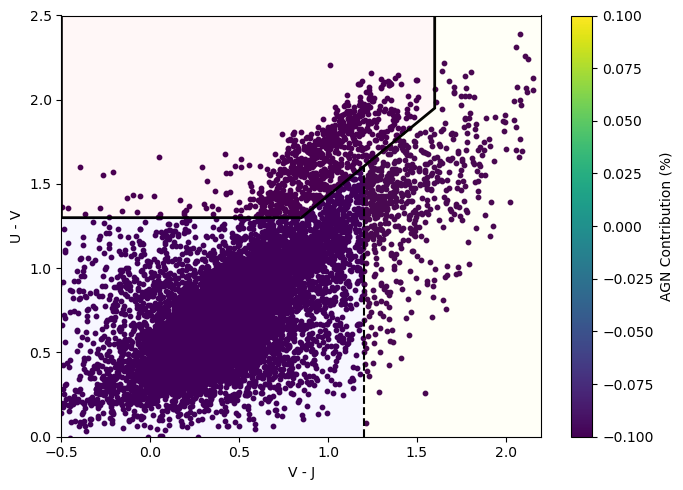

In [51]:
# Maybe just plot an all redshift UVJ diagram 
fig, axs = plt.subplots(1, 1, figsize=fig_size_params, sharex=True, sharey=True)


alpha_values = [0]
for m in range(len(alpha_values)):
    # Get the filter magnitudes
    U_mag = composite_fluxes[f'U_{alpha_values[m]}']
    V_mag = composite_fluxes[f'V_{alpha_values[m]}']
    J_mag = composite_fluxes[f'J_{alpha_values[m]}']
    
    # Create the colours
    uv = U_mag - V_mag
    vj = V_mag - J_mag
    
    # Add the uv and vj values to the average_redshift_colours dictionary
    # only for the 100 AGN contribution

    # Plot scatter
    axs.scatter(vj, uv, c=[colours_theme[m]], s=10)
    

        
    
    
    
    # We will obtain the Star-forming, Quiescent, and Dusty Fractions for this particular alpha value     
    # Obtain the number of galaxies with sf region dictated by the sf path
    # Create Path objects from your path coordinates (do this once, outside the loop)
    path_quiescent_obj = mpath.Path(path_quiescent)
    path_sf_obj = mpath.Path(path_sf)
    path_sfd_obj = mpath.Path(path_sfd)

    # # Create a DataFrame with just the uv and vj columns for easier selection
    # uvj_data = pd.DataFrame({'vj': vj, 'uv': uv})

    # # Perform the selection
    # quiescent_seds = uvj_data[path_quiescent_obj.contains_points(uvj_data.values)]
    # sf_seds = uvj_data[path_sf_obj.contains_points(uvj_data.values)]
    # sfd_seds = uvj_data[path_sfd_obj.contains_points(uvj_data.values)]
    
    # # Print the number of galaxies in each region
    # print("Quiescent: ", len(quiescent_seds))
    # print("Star-forming: ", len(sf_seds))
    # print("Dusty: ", len(sfd_seds))
    
    
    # # Calculate the fractions
    # galaxy_fractions['Quiescent'].append(len(quiescent_seds) / num_galaxies)
    # galaxy_fractions['Star-forming'].append(len(sf_seds) / num_galaxies)
    # galaxy_fractions['Dusty'].append(len(sfd_seds) / num_galaxies)
    
    
    # Add patches for selections
axs.add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
axs.add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
axs.add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

# Add vertical line
axs.axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)

# Add axis labels
axs.set_xlabel("V - J")
axs.set_ylabel("U - V")


# AGN Colour Evolution title - just call it redshift
# axs.set_title(f"Colour Evolution for ZFOURGE Composites")

# Ensure limits
axs.set_xlim(-0.5, 2.2)
axs.set_ylim(0, 2.5)
    # Make the subplots closer together
# plt.subplots_adjust(wspace=0.05, hspace=0.3)

# Add a colourbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
cbar = plt.colorbar(sm, ax=axs)

# Name the colorbar
cbar.set_label('AGN Contribution (%)')


plt.tight_layout()




# Save 
if save_figures:
    plt.savefig(f'outputs/ThesisPlots/UVJ_{agn_model_name}_ZFOURGE_all.png')

plt.show()
alpha_values = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

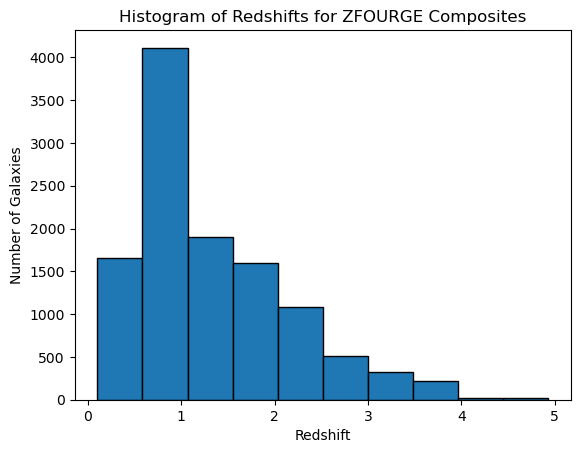

In [52]:
# Print the histogram of the redshifts
plt.hist(composite_fluxes['z'], bins=10, edgecolor='black')
plt.xlabel('Redshift')
plt.ylabel('Number of Galaxies')
plt.title('Histogram of Redshifts for ZFOURGE Composites')
plt.show()


{'Star-forming': [0.8688095030133636, 0.877369202550441, 0.8848807756135907, 0.8915189099484672, 0.8991178268844441, 0.9074154948030395, 0.9151017556118438, 0.921390514455411, 0.9283780242815967, 0.9349288147436458, 0.9425277316796227], 'Quiescent': [0.06830290855096514, 0.06227618132587999, 0.05581273473665822, 0.049960695257227704, 0.044458031269106475, 0.03799458467988471, 0.03336535942003668, 0.028736134160188664, 0.02323347017206743, 0.018516901039392086, 0.013101580924098175], 'Dusty': [0.05196960433225609, 0.051358197222464846, 0.05144554109529217, 0.05153288496811949, 0.051096165603982883, 0.05031007074853699, 0.048388505546335926, 0.046991003581098784, 0.04594287710717093, 0.044545375141933796, 0.04262380993973273]}


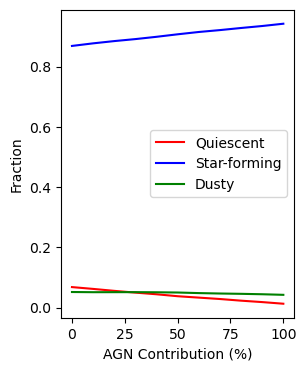

,Star-forming,Quiescent,Dusty
0,0.868810,0.068303,0.051970
10,0.877369,0.062276,0.051358
20,0.884881,0.055813,0.051446
30,0.891519,0.049961,0.051533
40,0.899118,0.044458,0.051096
50,0.907415,0.037995,0.050310
60,0.915102,0.033365,0.048389
70,0.921391,0.028736,0.046991
80,0.928378,0.023233,0.045943
90,0.934929,0.018517,0.044545


In [53]:
# # Check the fractions 
galaxy_fractions
print(galaxy_fractions)

fraction_figsize = (3, 4)
# Plot the fractions
fig, ax = plt.subplots(figsize=fraction_figsize)
ax.plot(alpha_values, galaxy_fractions['Quiescent'], label='Quiescent', color='red')
ax.plot(alpha_values, galaxy_fractions['Star-forming'], label='Star-forming', color='blue')
ax.plot(alpha_values, galaxy_fractions['Dusty'], label='Dusty', color='Green')

# Add labels
ax.set_xlabel(f'AGN Contribution (%)')
ax.set_ylabel('Fraction')
#ax.set_title('Fraction of Galaxies in UVJ Diagram')
ax.legend()

# Save the output
if save_figures:
    plt.savefig(f'outputs/ThesisPlots/UVJ_galfractions_{agn_model_name}_{template_set_name}.png')
    
# Show the output
plt.show()

# Also convert the fractions to a dataframe
galaxy_fractions_df = pd.DataFrame(galaxy_fractions, index=alpha_values)



if save_figures:
    galaxy_fractions_df.to_csv(f'outputs/ThesisPlots/UVJ_fractions_{agn_model_name}_{template_set_name}.csv')

galaxy_fractions_df

# ugr


count    11449.000000
mean         1.320493
std          0.816668
min          0.102800
25%          0.709500
50%          1.061300
75%          1.769000
max          4.929900
Name: z, dtype: float64
Correct Identification: 464
Correct Non-UGR Identification: 10532
Misidentification: 139
Missed Selection: 314
Correct Identification: 419
Correct Non-UGR Identification: 10516
Misidentification: 155
Missed Selection: 359
Correct Identification: 383
Correct Non-UGR Identification: 10513
Misidentification: 158
Missed Selection: 395
Correct Identification: 344
Correct Non-UGR Identification: 10530
Misidentification: 141
Missed Selection: 434
Correct Identification: 310
Correct Non-UGR Identification: 10567
Misidentification: 104
Missed Selection: 468
Correct Identification: 268
Correct Non-UGR Identification: 10590
Misidentification: 81
Missed Selection: 510


C:\Users\Titan\AppData\Local\Temp\ipykernel_35220\130402756.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_seds['redshift'] = redshifts_selected
C:\Users\Titan\AppData\Local\Temp\ipykernel_35220\130402756.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_selected_seds['redshift'] = redshifts_non_selected
C:\Users\Titan\AppData\Local\Temp\ipykernel_35220\130402756.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

Correct Identification: 225
Correct Non-UGR Identification: 10606
Misidentification: 65
Missed Selection: 553
Correct Identification: 179
Correct Non-UGR Identification: 10628
Misidentification: 43
Missed Selection: 599
Correct Identification: 148
Correct Non-UGR Identification: 10641
Misidentification: 30
Missed Selection: 630
Correct Identification: 115
Correct Non-UGR Identification: 10653
Misidentification: 18
Missed Selection: 663
Correct Identification: 88
Correct Non-UGR Identification: 10661
Misidentification: 10
Missed Selection: 690


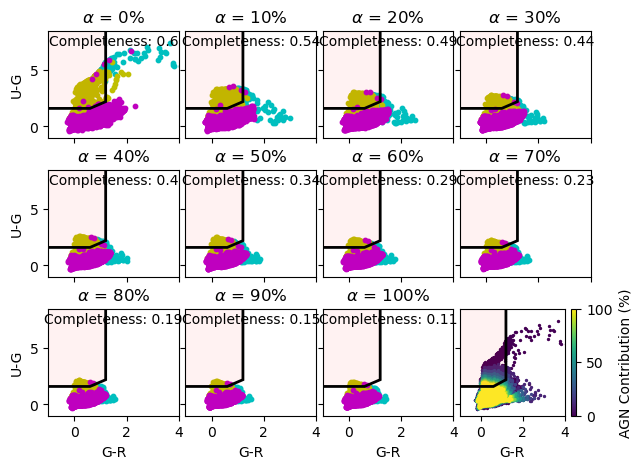

In [54]:
# ugr Diagram
fig, axs = plt.subplots(3, 4, figsize=fig_size_params, sharex=True, sharey=True)
# have a look at the distibution for the composite_fluxes
print(composite_fluxes['z'].describe())


selection_statistics = {'Missed Selection': [], 'Misidentification': [], 'Correct Identification': [], 'Correct Non-UGR Identification': []}
# Realistically we are only interested in the correct identification and missed selection, but we will include all.
num_galaxies = len(composite_fluxes) # Because we consider all redshit ranges

# Completeness and contamination table
completeness_stats = {'Completeness': [] }


for n in range(len(alpha_values)):
    # Get the u, g, and r magnitudes for the specific alpha value
    u_col_name = f'u_{int(round(alpha_values[n], 2))}'
    g_col_name = f'g_{int(round(alpha_values[n], 2))}'
    r_col_name = f'r_{int(round(alpha_values[n], 2))}'
    
    # Create the colours for the UGR diagram
    ug_specific_alpha_colours = composite_fluxes[u_col_name] - composite_fluxes[g_col_name]
    gr_specific_alpha_colours = composite_fluxes[g_col_name] - composite_fluxes[r_col_name]

    # Scatter plots with color-coded redshift ranges
    axs[n // 4, n % 4].scatter(gr_specific_alpha_colours[composite_fluxes['z'] > 3.5], 
                               ug_specific_alpha_colours[composite_fluxes['z'] > 3.5], 
                               c="c", s=10, label="z > 3.5")

    axs[n // 4, n % 4].scatter(gr_specific_alpha_colours[(composite_fluxes['z'] > 2.6) & (composite_fluxes['z'] <= 3.5)], 
                               ug_specific_alpha_colours[(composite_fluxes['z'] > 2.6) & (composite_fluxes['z'] <= 3.5)], 
                               c="y", s=10, label="2.6 < z < 3.5")

    axs[n // 4, n % 4].scatter(gr_specific_alpha_colours[composite_fluxes['z'] < 2.6], 
                               ug_specific_alpha_colours[composite_fluxes['z'] < 2.6], 
                               c="m", s=10, label="z < 2.6")
    
    
    # Set the AGN Contribution title 
    axs[n//4, n%4].set_title(rf'$\alpha$ = {alpha_values[n]}%')
    
    plt.xlabel("")
    plt.ylabel("")
    #plt.title("UGR Diagram for SED Templates at Different Redshifts(0 < z < 4) for alpha = {}".format(alphas[n]))

      
    # Set the axis labels
    if n//4 == 2:
        axs[n//4, n%4].set_xlabel("G-R")
    if n%4 == 0:
        axs[n//4, n%4].set_ylabel("U-G")
    
    
    # add the alpha value information onto the plot somewhere
    #axs[n//4, n%4].text(0.5, 0.9, f"alpha = {round(alpha[n], 2)}", horizontalalignment='center', verticalalignment='center', transform=axs[n//4, n%4].transAxes)

    # Additionally we can plot the UGR selection criteria on the UGR diagram
    U_rule = [[1.2,9], [1.2,2.2], [0.6,1.6], [-3,1.6], [-3,9]]
    axs[n//4, n%4].add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout technique
    
    
    # The path here is the UGR selection criteria, we can find the selected points in this particular population using the path
    # Create Path objects from your path coordinates (do this once, outside the loop)
    path = mpath.Path(U_rule)
    
    # Create a DataFrame with just the u-g and g-r columns for easier selection
    ugr_data = pd.DataFrame({'gr': gr_specific_alpha_colours, 'ug': ug_specific_alpha_colours})
    
    # append the associated redshifts to the ugr data
    redshifts = composite_fluxes['z']
    
    # Selection stats go here:
    # Perform the selection
    selected_seds = ugr_data[path.contains_points(ugr_data.values)]
    non_selected_seds = ugr_data[~path.contains_points(ugr_data.values)]
    
    # Using the id of the selected seds, we can find the associated redshift values
    redshifts_selected = redshifts[selected_seds.index]
    redshifts_non_selected = redshifts[non_selected_seds.index]
    
    # We can then append the redshifts to the selected seds
    selected_seds['redshift'] = redshifts_selected
    non_selected_seds['redshift'] = redshifts_non_selected
    
    # using the above data we can calculate the fractions
    correct_ugr_selection = selected_seds[(selected_seds['redshift'] >= 2.6) & (selected_seds['redshift'] <= 3.5)]
    correct_nonugr_selection = non_selected_seds[(non_selected_seds['redshift'] < 2.6) | (non_selected_seds['redshift'] > 3.5)]
    
    # Combine the above to be a correct identification
    #correct_identification = correct_ugr_selection.append(correct_nonugr_selection)
    
    # Misidentification - a selected sed that was not in the redshift range we were after - incorrect redshift range
    misidentification = selected_seds[(selected_seds['redshift'] < 2.6) | (selected_seds['redshift'] > 3.5)]
    
    # Missed Selection - a non-selected sed SED that was in the redshift range we were after, something we missed.
    missed_selection = non_selected_seds[(non_selected_seds['redshift'] >= 2.6) & (non_selected_seds['redshift'] <= 3.5)]
    
    
    # Print the numbers without the fractions
    print(f"Correct Identification: {len(correct_ugr_selection)}")
    print(f"Correct Non-UGR Identification: {len(correct_nonugr_selection)}")
    print(f"Misidentification: {len(misidentification)}")
    print(f"Missed Selection: {len(missed_selection)}")
    
    
    
    
    # # Calculate the fractions
    # selection_statistics['Correct Identification'].append(len(correct_ugr_selection) / num_galaxies)
    # selection_statistics['Correct Non-UGR Identification'].append(len(correct_nonugr_selection) / num_galaxies)
    # selection_statistics['Misidentification'].append(len(misidentification) / num_galaxies)
    # selection_statistics['Missed Selection'].append(len(missed_selection) / num_galaxies)
    
    # Instead of fractions, we can just append the numbers
    selection_statistics['Correct Identification'].append(len(correct_ugr_selection))
    selection_statistics['Correct Non-UGR Identification'].append(len(correct_nonugr_selection))
    selection_statistics['Misidentification'].append(len(misidentification))
    selection_statistics['Missed Selection'].append(len(missed_selection))
    
    # We can also quantify the completeness and contamination of the selection
    # Completeness = Correct Identification / (Correct Identification + Missed Selection)
    # Contamination = Misidentification / (Correct Identification + Misidentification)
    
    completeness = len(correct_ugr_selection) / (len(correct_ugr_selection) + len(missed_selection))
    #contamination = len(misidentification) / (len(correct_ugr_selection) + len(misidentification))
    
    # Append the values
    completeness_stats['Completeness'].append(completeness)
    
    
    # Plot the completeness
    axs[n//4, n%4].text(0.5, 0.9, f"Completeness: {round(completeness, 2)}", horizontalalignment='center', verticalalignment='center', transform = axs[n//4, n%4].transAxes)
    
    
    axs[n//4, n%4].set_xlim(-1, 4)
    axs[n//4, n%4].set_ylim(-1, 8.5)
    
    
for m in range(len(alpha_values)):
    
    
    
    # Recall that this is only a restframe diagram, so only look at the restframe colours
    u_col_name = f'u_{int(round(alpha_values[m], 2))}'
    g_col_name = f'g_{int(round(alpha_values[m], 2))}'
    r_col_name = f'r_{int(round(alpha_values[m], 2))}'
    
    # Create the colours for the UGR diagram
    ug_specific_alpha_colours = composite_fluxes[u_col_name] - composite_fluxes[g_col_name]
    gr_specific_alpha_colours = composite_fluxes[g_col_name] - composite_fluxes[r_col_name]
    
    # Scatter plots with color-coded redshift ranges
    axs[2, 3].scatter(gr_specific_alpha_colours, 
                               ug_specific_alpha_colours, 
                               c=colours_theme[m], s=2)


    
    
    # In addition we can plot a mean position for on each of the alpha plots. This mean value will be the mean of the ugr

# Additionally we can plot the UGR selection criteria on the UGR diagram
U_rule = [[1.2,9], [1.2,2.2], [0.6,1.6], [-3,1.6], [-3,9]]
axs[2, 3].add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout technique

axs[2, 3].set_xlim(-1, 4)
axs[2, 3].set_ylim(-1, 8.5)

axs[2, 3].set_xlabel("G-R")


sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
cbar = plt.colorbar(sm, ax=axs[2, 3])

# Add the AGN Contribution label
cbar.set_label('AGN Contribution (%)')

    
    
    # Make the subplots closer together
plt.subplots_adjust(wspace=0.05, hspace=0.3)
    

# if save_figures:
#     plt.savefig(f'outputs/ThesisPlots/ugr_evolution_{agn_model_name}_{template_set_name}.png')
    
# Plot
plt.show()

# As i don't have any extra redshift information this is accurately producing the right redshift information
# While there is limited redshift information, this does seem to be showing somewhat correct identification for low redshifts.

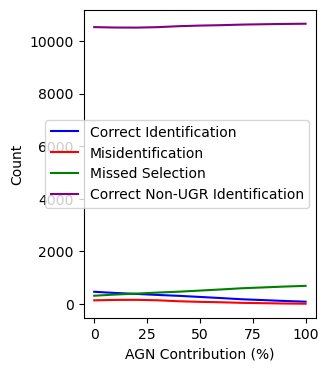

In [55]:
selection_statistics_df = pd.DataFrame(selection_statistics, index=alpha_values)

# Plot the fractions
fig, ax = plt.subplots(figsize=(3, 4))
ax.plot(alpha_values, selection_statistics['Correct Identification'], label='Correct Identification', color='blue')
ax.plot(alpha_values, selection_statistics['Misidentification'], label='Misidentification', color='red')
ax.plot(alpha_values, selection_statistics['Missed Selection'], label='Missed Selection', color='green')
ax.plot(alpha_values, selection_statistics['Correct Non-UGR Identification'], label='Correct Non-UGR Identification', color='purple')

# Add labels
ax.set_xlabel(f'AGN Contribution (%)')
ax.set_ylabel('Count')
#ax.set_title('Fraction of Galaxies in UGR Diagram')
ax.legend()

# Save the output
if save_figures:
    plt.savefig(f'outputs/ThesisPlots/ugr_selection_fractions_{agn_model_name}_{template_set_name}.png')
    
# Show the output
plt.show()

selection_statistics_df

# We would like to output the selection statistics to a csv file
if save_figures:
    selection_statistics_df.to_csv(f'outputs/ThesisPlots/ugr_selection_fractions_{agn_model_name}_{template_set_name}.csv')
    

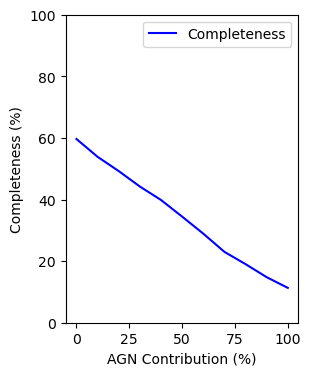

In [56]:
# Also plot the completeness and contamination statistics for each alpha
completeness_stats_df = pd.DataFrame(completeness_stats, index=alpha_values)

# add new column for completeness (convert to percentages)
completeness_stats_df['Completeness (%)'] = completeness_stats_df['Completeness'] * 100

# Plot the fractions
fig, ax = plt.subplots(figsize=(3, 4))

# Plot the completeness percentages
ax.plot(alpha_values, completeness_stats_df['Completeness (%)'], label='Completeness', color='blue')

# Add labels
ax.set_xlabel(f'AGN Contribution (%)')
ax.set_ylabel('Completeness (%)')
#ax.set_title('Fraction of Galaxies in UGR Diagram')
ax.legend()


# Set the ylim to 100
ax.set_ylim(0, 100)

# Save the output
if save_figures:
    plt.savefig(f'outputs/ThesisPlots/ugr_completeness_contamination_{agn_model_name}_{template_set_name}.png')
    
# Show the output
plt.show()

completeness_stats_df

# change the index to a column named alpha
# Create new column for alpha
completeness_stats_df['AGN Contribution (%)'] = completeness_stats_df.index
completeness_stats_df.reset_index(inplace=False).copy()

# Save the completeness percentages and AGN contribution to a csv file
if save_figures:
    completeness_stats_df[['AGN Contribution (%)', 'Completeness (%)']].to_csv(f'outputs/ThesisPlots/ugr_completeness_Contribution_{agn_model_name}_{template_set_name}.csv')

ug_specific_alpha_colours:  362      4.075746
701      5.199418
746      5.857260
953      4.396414
977      4.169850
           ...   
11378    4.392318
11399    4.242232
11409    5.479775
11416    4.641955
11434    4.352530
Length: 220, dtype: float64
gr_specific_alpha_colours:  0        0.030781
1        0.529532
2       -0.037108
3        0.811559
4        0.448984
           ...   
11444    1.609188
11445    0.089302
11446    0.602531
11447   -0.200007
11448   -0.023551
Length: 11449, dtype: float64
UDS_1597


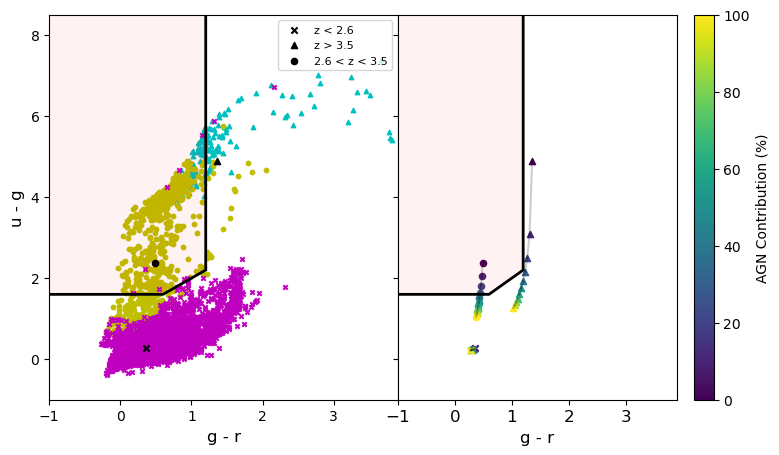

In [57]:
#
spacing = len(alpha_values)
colours_theme = plt.cm.viridis(np.linspace(0, 1, spacing))

# Do a double plot just for the last 
fig, axs = plt.subplots(1, 2, figsize=(9, 5), sharex=True, sharey=True)

# # Get the u, g, and r magnitudes for the specific alpha value

u_col_name = f'u_{int(round(alpha_values[0], 2))}'
g_col_name = f'g_{int(round(alpha_values[0], 2))}'
r_col_name = f'r_{int(round(alpha_values[0], 2))}'

# Create the colours for the UGR diagram
ug_specific_alpha_colours = composite_fluxes[u_col_name] - composite_fluxes[g_col_name]
gr_specific_alpha_colours = composite_fluxes[g_col_name] - composite_fluxes[r_col_name]


print("ug_specific_alpha_colours: ", ug_specific_alpha_colours[composite_fluxes['z'] > 3.5])
print("gr_specific_alpha_colours: ", gr_specific_alpha_colours)


# Scatter plots with color-coded redshift ranges
axs[0].scatter(gr_specific_alpha_colours[composite_fluxes['z'] > 3.5], 
                            ug_specific_alpha_colours[composite_fluxes['z'] > 3.5], 
                            c="c", s=10, marker='^')

axs[0].scatter(gr_specific_alpha_colours[(composite_fluxes['z'] > 2.6) & (composite_fluxes['z'] <= 3.5)], 
                            ug_specific_alpha_colours[(composite_fluxes['z'] > 2.6) & (composite_fluxes['z'] <= 3.5)], 
                            c="y", s=10, marker='o')

axs[0].scatter(gr_specific_alpha_colours[composite_fluxes['z'] < 2.6], 
                            ug_specific_alpha_colours[composite_fluxes['z'] < 2.6], 
                            c="m", s=10, marker='x')





# Choose the average position
# # SF
# sf_galaxies = np.where(sf_galaxies)[0]

# # Calc average position (vj, uv)
# sf_uv = np.mean(uv[sf_galaxies])
# sf_vj = np.mean(vj[sf_galaxies])

# # Look for a galaxy that is the closest to the average position
# sf_galaxy = np.argmin((vj[sf_galaxies] - sf_vj)**2 + (uv[sf_galaxies] - sf_uv)**2)
# sf_galaxy = sf_galaxies[sf_galaxy]

less_than_2_6 = composite_fluxes[composite_fluxes['z'] < 2.6]
greater_than_3_5 = composite_fluxes[composite_fluxes['z'] > 3.5]
target_redshift = composite_fluxes[(composite_fluxes['z'] > 2.6) & (composite_fluxes['z'] <= 3.5)]

# Calculate the average position for less than 2.6
less_than_2_6_uv = np.mean(ug_specific_alpha_colours[less_than_2_6.index])
less_than_2_6_vj = np.mean(gr_specific_alpha_colours[less_than_2_6.index])

# Look for a galaxy that is the closest to the average position
less_than_2_6_galaxy = np.argmin((gr_specific_alpha_colours[less_than_2_6.index] - less_than_2_6_vj)**2 + (ug_specific_alpha_colours[less_than_2_6.index] - less_than_2_6_uv)**2)
less_than_2_6_galaxy = less_than_2_6.index[less_than_2_6_galaxy]

less_than_2_6_galaxy_id = composite_fluxes.iloc[less_than_2_6_galaxy]['id']

# Calculate the average position for greater than 3.5
greater_than_3_5_uv = np.mean(ug_specific_alpha_colours[greater_than_3_5.index])
greater_than_3_5_vj = np.mean(gr_specific_alpha_colours[greater_than_3_5.index])

# Look for a galaxy that is the closest to the average position
greater_than_3_5_galaxy = np.argmin((gr_specific_alpha_colours[greater_than_3_5.index] - greater_than_3_5_vj)**2 + (ug_specific_alpha_colours[greater_than_3_5.index] - greater_than_3_5_uv)**2)
greater_than_3_5_galaxy = greater_than_3_5.index[greater_than_3_5_galaxy]

greater_than_3_5_galaxy_id = composite_fluxes.iloc[greater_than_3_5_galaxy]['id']

# Calculate the average position for the target redshift
target_uv = np.mean(ug_specific_alpha_colours[target_redshift.index])
target_vj = np.mean(gr_specific_alpha_colours[target_redshift.index])

# Look for a galaxy that is the closest to the average position
target_galaxy = np.argmin((gr_specific_alpha_colours[target_redshift.index] - target_vj)**2 + (ug_specific_alpha_colours[target_redshift.index] - target_uv)**2)
target_galaxy = target_redshift.index[target_galaxy]

# offsets
less_offset = []
greater_offset = []
target_offset = []

# get id
target_galaxy_id = composite_fluxes.iloc[target_galaxy]['id']

# Plot the average positions
axs[0].scatter(gr_specific_alpha_colours[less_than_2_6_galaxy], 
                            ug_specific_alpha_colours[less_than_2_6_galaxy], 
                            c="k", s=20, label="z < 2.6", marker='x') 

axs[0].scatter(gr_specific_alpha_colours[greater_than_3_5_galaxy],
                            ug_specific_alpha_colours[greater_than_3_5_galaxy], 
                            c="k", s=20, label="z > 3.5", marker='^')

axs[0].scatter(gr_specific_alpha_colours[target_galaxy],        
                            ug_specific_alpha_colours[target_galaxy], 
                            c="k", s=20, label="2.6 < z < 3.5", marker='o')




colours_theme = plt.cm.viridis(np.linspace(0, 1, len(alpha_values)))

# Plot the colour evolution - Instead do a similar plot to the UVJ diagram, and pick an average point in each redshift range, the plot the colour evolution of that point
print(target_galaxy_id)

# Subset the composite to only include the galaxies by id, and their associated colours
composite_subset = composite_fluxes[(composite_fluxes['id'] == target_galaxy_id) | (composite_fluxes['id'] == less_than_2_6_galaxy_id) | (composite_fluxes['id'] == greater_than_3_5_galaxy_id)]


composite_subset.reset_index(drop=True, inplace=True)
# Reset index

composite_subset



# Now do the second plot
for m in range(len(alpha_values)):   
    
   
    

   # Recall that this is only a restframe diagram, so only look at the restframe colours
    u_col_name = f'u_{int(round(alpha_values[m], 2))}'
    g_col_name = f'g_{int(round(alpha_values[m], 2))}'
    r_col_name = f'r_{int(round(alpha_values[m], 2))}'
    
    # Create the colours for the UGR diagram
    ug_specific_alpha_colours = composite_subset[u_col_name] - composite_subset[g_col_name]
    gr_specific_alpha_colours = composite_subset[g_col_name] - composite_subset[r_col_name]
    
    # # Scatter plots with color-coded redshift ranges
    # axs[1].scatter(gr_specific_alpha_colours, 
    #                            ug_specific_alpha_colours, 
    #                            c=colours_theme[m], s=2)
    
    # Print colours
    #print(f"ug_specific_alpha_colours: {ug_specific_alpha_colours}")
    #print(f"gr_specific_alpha_colours: {gr_specific_alpha_colours}")
    
    
    if m == 0:
        inital_ug_less = ug_specific_alpha_colours[0]
        inital_gr_less = gr_specific_alpha_colours[0]
        inital_ug_greater = ug_specific_alpha_colours[1]
        inital_gr_greater = gr_specific_alpha_colours[1]
        inital_ug_target = ug_specific_alpha_colours[2]
        inital_gr_target = gr_specific_alpha_colours[2]
    else:
        # calculate the vector magnitude offset
        less_offset.append(np.sqrt((ug_specific_alpha_colours[0] - inital_ug_less)**2 + (gr_specific_alpha_colours[0] - inital_gr_less)**2))
        greater_offset.append(np.sqrt((ug_specific_alpha_colours[1] - inital_ug_greater)**2 + (gr_specific_alpha_colours[1] - inital_gr_greater)**2))
        target_offset.append(np.sqrt((ug_specific_alpha_colours[2] - inital_ug_target)**2 + (gr_specific_alpha_colours[2] - inital_gr_target)**2))
                             
        
    
    
    
    
    # Plot a faint line from on alpha value to the next
    if m < (len(alpha_values) - 1):
        
        # Recall that this is only a restframe diagram, so only look at the restframe colours
        u_col_name_next = f'u_{int(round(alpha_values[m+1], 2))}'
        g_col_name_next = f'g_{int(round(alpha_values[m+1], 2))}'
        r_col_name_next = f'r_{int(round(alpha_values[m+1], 2))}'
        
        # Create the colours for the UGR diagram
        ug_specific_alpha_colours_next = composite_subset[u_col_name_next] - composite_subset[g_col_name_next]
        gr_specific_alpha_colours_next = composite_subset[g_col_name_next] - composite_subset[r_col_name_next]
        

        # Plot line
        axs[1].plot([gr_specific_alpha_colours, gr_specific_alpha_colours_next], [ug_specific_alpha_colours, ug_specific_alpha_colours_next], 'k-', alpha=0.2)
    
    
    # Plot scatter - use different symbol for each plotted galaxy, but still use the colour scheme - 
    # Ensure we plot each of the regions with different symbols
    # Plot
    axs[1].scatter(gr_specific_alpha_colours[0], 
                            ug_specific_alpha_colours[0], 
                            c=[colours_theme[m]], s=20, label="z < 2.6", marker='x')
    
    axs[1].scatter(gr_specific_alpha_colours[1],
                            ug_specific_alpha_colours[1], 
                            c=[colours_theme[m]], s=20, label="z > 3.5", marker='^')
    
    axs[1].scatter(gr_specific_alpha_colours[2],
                            ug_specific_alpha_colours[2], 
                            c=[colours_theme[m]], s=20, label="2.6 < z < 3.5", marker='o')
    
    
    
    
    
# Set the AGN Contribution title
#axs[0].set_title('')



plt.xlabel("")
plt.ylabel("")
#plt.title("UGR Diagram for SED Templates at Different Redshifts(0 < z < 4) for alpha = {}".format(alphas[n]))

# Add colourbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
cbar = plt.colorbar(sm, ax=axs[1])

# Name the colorbar
cbar.set_label('AGN Contribution (%)')



# add the alpha value information onto the plot somewhere
#axs[n//4, n%4].text(0.5, 0.9, f"alpha = {round(alpha[n], 2)}", horizontalalignment='center', verticalalignment='center', transform=axs[n//4, n%4].transAxes)

# Additionally we can plot the UGR selection criteria on the UGR diagram
U_rule = [[1.2,9], [1.2,2.2], [0.6,1.6], [-3,1.6], [-3,9]]

# Add patch to correct plot
axs[0].add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout


# Add patch to correct plot
axs[1].add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout


# The path here is the UGR selection criteria, we can find the selected points in this particular population using the path
# Create Path objects from your path coordinates (do this once, outside the loop)
path = mpath.Path(U_rule)

# Create a DataFrame with just the u-g and g-r columns for easier selection
ugr_data = pd.DataFrame({'gr': gr_specific_alpha_colours, 'ug': ug_specific_alpha_colours})

# append the associated redshifts to the ugr data
redshifts = composite_fluxes['z']

# Set limits
plt.xlim(-1, 3.9)
plt.ylim(-1, 8.5)
# ensure axis label font size is correct
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# # rotate bothe axis
# axs[1].tick_params(axis='x', rotation=45)

# axs[0].tick_params(axis='x', rotation=45)

# For each axis, label accordingly
axs[0].set_xlabel("g - r", fontsize=12)
axs[0].set_ylabel("u - g", fontsize=12)

axs[1].set_xlabel("g - r", fontsize=12)

# Add legend on the first plot
axs[0].legend(loc='upper right', fontsize=8)


# adjust space
plt.subplots_adjust(wspace=0.0, hspace=0.3)


# Save
if save_figures:
    plt.savefig(f'outputs/ThesisPlots/ugr_evolution_{agn_model_name}_ZFOURGE_comparison.png', dpi=300, bbox_inches='tight')

plt.show()

In [58]:
# get information on each of the redshift bin galaxies
output_df = composite_fluxes[composite_fluxes['id'].isin([less_than_2_6_galaxy_id, greater_than_3_5_galaxy_id, target_galaxy_id])].copy()

# Create a new dataframe from above showing the ID, redshift, and the bin they are cateogrised in

# Create a new column for the redshift bin
new_df = pd.DataFrame({'ID': output_df['id'], 'Redshift': output_df['z'], 'Bin': ['z < 2.6', 'z > 3.5', '2.6 < z < 3.5']})



In [59]:
new_df 
# Switch rows 1, and 2
new_df.iloc[1], new_df.iloc[2] = new_df.iloc[2].copy(), new_df.iloc[1].copy()


In [60]:
new_df.to_csv(f'outputs/ThesisPlots/{composite_choice}_EAZY_ugr_galaxies.csv')


In [61]:
# # ugr space
# vector_magnitude_table = pd.DataFrame(columns=alpha_values[1:], index=['Type 1', 'Type 2'])

# for type in types:
#     if type == 'Type 1':
#         composite_fluxes = composite_fluxes_type1
#     else:
#         composite_fluxes = composite_fluxes_type2
        
#     for alpha in alpha_values:
#         # Get the u, g, and r magnitudes for the specific alpha value
#         u_col_name = f'u_{int(round(alpha, 2))}'
#         g_col_name = f'g_{int(round(alpha, 2))}'
#         r_col_name = f'r_{int(round(alpha, 2))}'

#         # Create the colours for the UGR diagram
#         ug_specific_alpha_colours = composite_fluxes[u_col_name] - composite_fluxes[g_col_name]
#         gr_specific_alpha_colours = composite_fluxes[g_col_name] - composite_fluxes[r_col_name]


#         if alpha == 0:
#             # uv and vj initial values
#             ug_initial = ug_specific_alpha_colours
#             gr_initial = gr_specific_alpha_colours
            
#             # Get the average location
#             ug_mean_inital = np.mean(ug_initial)
#             gr_mean_inital = np.mean(gr_initial)
            
#             # print the mean location
#             #print(f"Mean Location for alpha = {alpha_values[m]}: ({vj_mean_inital}, {vj_mean_inital})")
            
#         else:
#             # Get the vector magnitude
#             # Get the average location
#             ug_mean = np.mean(ug_specific_alpha_colours)
#             gr_mean = np.mean(gr_specific_alpha_colours)
            
#             # print the mean location
#             #print(f"Mean Location for alpha = {alpha_values[m]}: ({vj_mean}, {uv_mean})")
            
#             # calculate the absolute vector magnitude difference
#             vector_magnitude_diff = np.sqrt((ug_mean - ug_mean_inital)**2 + (gr_mean - gr_mean_inital)**2)
                
#             # Add the vector magnitude to the table
#             vector_magnitude_table.loc[type, alpha] = vector_magnitude_diff
            
# if save_figures:
#     vector_magnitude_table.to_csv(f'outputs/ThesisPlots/UGR_VectorMagnitudeDifference_{agn_model_names[0]}_{agn_model_names[1]}_{template_set_name}.csv')
    
# # Check the output
# vector_magnitude_table

In [62]:
offset_df = pd.DataFrame({'z < 2.6': less_offset, '2.6 < z < 3.6': target_offset, 'z > 3.5': greater_offset}, index=alpha_values[1:])


In [63]:
# print
offset_df

# save 
if save_figures:
    offset_df.to_csv(f'outputs/ThesisPlots/UGR_{composite_choice}_offsets.csv')

# IRAC 

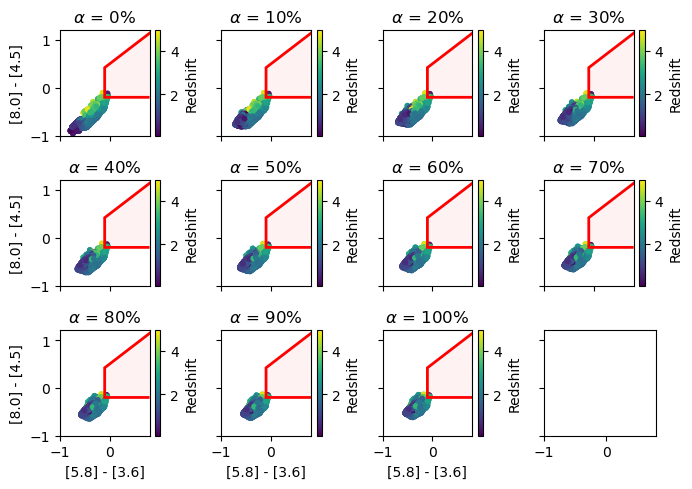

In [64]:
# Choose the diagram min and max
xmax = 0.8
ymax = 1.2
xmin = -1
ymin = -1

# Can change this to ensure we are only looking at the rest frame stuff
upper_redshift_limit = 0
lower_redshift_limit = 3.9

# setup 
fig, axs = plt.subplots(3, 4, figsize=fig_size_params, sharex=True, sharey=True)
for n in range(len(alpha_values)):
    
    # Get the IRAC magnitudes
    f_36 = composite_fluxes[f'IRAC3.6_{alpha_values[n]}']
    f_45 = composite_fluxes[f'IRAC4.5_{alpha_values[n]}']
    f_58 = composite_fluxes[f'IRAC5.8_{alpha_values[n]}']
    f_80 = composite_fluxes[f'IRAC8.0_{alpha_values[n]}']
    
    # Create the colours for the IRAC diagram
    f_5836_specific_alpha_colours = np.log10(f_58/f_36)
    f_8045_specific_alpha_colours = np.log10(f_80/f_45)

    # Redefine x and y for the first alpha value to plot the wedge
    x = f_5836_specific_alpha_colours
    y = f_8045_specific_alpha_colours
    
    
    
    # x = x[(composite_fluxes['z'] >= lower_redshift_limit) & (composite_fluxes['z'] <= upper_redshift_limit)]
    # y = y[(composite_fluxes['z'] >= lower_redshift_limit) & (composite_fluxes['z'] <= upper_redshift_limit)]
    
    
    
    # Reimplement the selection criteria 
    lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)
    
    # Colour code for each alpha - colour by redshift
    axs[n//4, n%4].scatter(x, y, c=composite_fluxes['z'], cmap='viridis', s=10)
    
    # Put a colour bar on the plot
    cbar = plt.colorbar(axs[n//4, n%4].scatter(x, y, c=composite_fluxes['z'], cmap='viridis', s=10), ax=axs[n//4, n%4])
    cbar.set_label('Redshift')
    
    # axs[n//4, n%4].scatter(x[lacy_selection_condition], y[lacy_selection_condition], c='blue', s=10)
    # axs[n//4, n%4].scatter(x[~lacy_selection_condition], y[~lacy_selection_condition], c='grey', s=10)
    
    
    # Get the IRAC magnitudes
    f_36 = composite_fluxes[f'IRAC3.6_{alpha_values[0]}']
    f_45 = composite_fluxes[f'IRAC4.5_{alpha_values[0]}']
    f_58 = composite_fluxes[f'IRAC5.8_{alpha_values[0]}']
    f_80 = composite_fluxes[f'IRAC8.0_{alpha_values[0]}']
    
    # Create the colours for the IRAC diagram
    f_5836_specific_alpha_colours = np.log10(f_58/f_36)
    f_8045_specific_alpha_colours = np.log10(f_80/f_45)
    
    
    # Redefine x and y for the first alpha value to plot the wedge
    x = f_5836_specific_alpha_colours
    y = f_8045_specific_alpha_colours
    
    # # Ensure we are only looking at the rest frame stuff
    # x = x[composite_fluxes['z'] == 0]
    # y = y[composite_fluxes['z'] == 0]

    # # Reimplement the selection criteria
    lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)
    wedge_vertices = [
        (xmax, -0.2),
        (-0.1, -0.2),
        (-0.1, 0.8*-0.1 + 0.5 ),  # Handle empty selection
        (((ymax-0.5)/0.8), ymax)
    ] 
    wedge_polygon = plt.Polygon(wedge_vertices, closed=False, edgecolor='r', facecolor=(1,0,0,0.05), linestyle='-', linewidth=2, label='Lacy Wedge')
    # Plot the polygon on the subplot
    axs[n//4, n%4].add_patch(wedge_polygon)
    
    
    # Set the AGN Contribution title
    axs[n//4, n%4].set_title(rf'$\alpha$ = {alpha_values[n]}%')
    
    # Set the axis labels
    if n//4 == 2:
        axs[n//4, n%4].set_xlabel("[5.8] - [3.6]")
    if n%4 == 0:
        axs[n//4, n%4].set_ylabel("[8.0] - [4.5]")
    
    # Set the axis limits
    axs[n//4, n%4].set_xlim(xmin, xmax)
    axs[n//4, n%4].set_ylim(ymin, ymax)
    
    
        
        
# Make the subplots closer together
plt.subplots_adjust(wspace=0.05, hspace=0.3)

plt.tight_layout()
# # Save the output
# if save_figures:
    
#     plt.savefig(f'outputs/ThesisPlots/IRAC_evolution_{agn_model_name}_{template_set_name}.png')


# Save the output
if save_figures:
    plt.savefig(f'outputs/ThesisPlots/IRAC_evolution_{agn_model_name}_ZFOURGE.png')
      
# Show the output
plt.show()

# These may not be appropriate for the redshifts that we are looking at, as we are looking at the rest frame values
# May have to look back at the drawing board and explore these in greater detail at a later date.



In [65]:
# Test completeness
# we will need to create a list of dictionaries
completeness_values = []

for n in range(len(alpha_values)):
    # at this alpha value, get the coordoinates
    # Get the IRAC magnitudes
    f_36 = composite_fluxes[f'IRAC3.6_{alpha_values[n]}']
    f_45 = composite_fluxes[f'IRAC4.5_{alpha_values[n]}']
    f_58 = composite_fluxes[f'IRAC5.8_{alpha_values[n]}']
    f_80 = composite_fluxes[f'IRAC8.0_{alpha_values[n]}']

    # Create the colours for the IRAC diagram
    f_5836_specific_alpha_colours = np.log10(f_58/f_36)
    f_8045_specific_alpha_colours = np.log10(f_80/f_45)

    # Redefine x and y for the first alpha value to plot the wedge
    x = f_5836_specific_alpha_colours
    y = f_8045_specific_alpha_colours


    print(len(x))
    # # Reimplement the selection criteria
    lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)
    
    num_sources_selected = x[lacy_selection_condition].notna().sum()
    
    print(num_sources_selected)
    # get the number of sources that are selected by the lacy wedge
    # num_sources_selected = len()
    # print(num_sources_selected)
    # for the first value of alpha there will be no relevance as there are no AGN, 
    # but we can instead check how many of all sources were selected
    if n == 0:
        num_sources_all = len(x)
        completeness = num_sources_selected/num_sources_all
        completeness_values.append({'alpha': alpha_values[n], 'completeness': completeness})
    else:
        completeness = num_sources_selected/num_sources_all
        completeness_values.append({'alpha': alpha_values[n], 'completeness': completeness})
        
# Create a pd.DataFrame
completeness_df = pd.DataFrame(completeness_values)


# save
if save_figures:
    completeness_df.to_csv(f'outputs/ThesisPlots/IRAC_completeness_{agn_model_name}_{template_set_name}.csv')

completeness_df

11449
7
11449
8
11449
8
11449
8
11449
8
11449
8
11449
8
11449
7
11449
6
11449
6
11449
6


,alpha,completeness
0,0,0.000611
1,10,0.000699
2,20,0.000699
3,30,0.000699
4,40,0.000699
5,50,0.000699
6,60,0.000699
7,70,0.000611
8,80,0.000524
9,90,0.000524


# ZFOURGE Average Moving Comparisons

In [66]:
# Do similar moving amount plots for the zfourge templates
# Read in both the type 1 and type 2 AGN models
template_set_name = 'ZFOURGE'
agn_model_names = ['Type1AGN', 'Type2AGN']


# read in the dataframe and ensure that the unamed: 0 column is the index
composite_choice_1 = f'{template_set_name}_obsevational_composites_fluxes{agn_model_names[0]}'
composite_choice_2 = f'{template_set_name}_obsevational_composites_fluxes{agn_model_names[1]}'
composite_fluxes_type1 = pd.read_csv(f'outputs\composite_seds\{composite_choice_1}.csv', index_col=0)   

composite_fluxes_type2 = pd.read_csv(f'outputs\composite_seds\{composite_choice_2}.csv', index_col=0)   


In [67]:
# Create table
vector_magnitude_table = pd.DataFrame(columns=alpha_values[1:], index=['Type 1', 'Type 2'])



# types
types = ['Type 1', 'Type 2']

for type in types: 
    if type == 'Type 1':
        composite_fluxes = composite_fluxes_type1
    else:
        composite_fluxes = composite_fluxes_type2
        
    for alpha in alpha_values:
        # Get the filter magnitudes
        U_mag = composite_fluxes[f'U_{alpha}']
        V_mag = composite_fluxes[f'V_{alpha}']
        J_mag = composite_fluxes[f'J_{alpha}']

        # Create the colours
        uv = U_mag - V_mag
        vj = V_mag - J_mag

        
        if alpha == 0:
            # uv and vj initial values
            uv_initial = uv
            vj_initial = vj
            
            # Get the average location
            uv_mean_inital = np.mean(uv_initial)
            vj_mean_inital = np.mean(vj_initial)
            
            # print the mean location
            #print(f"Mean Location for alpha = {alpha_values[m]}: ({vj_mean_inital}, {vj_mean_inital})")
            
        else:
            # Get the vector magnitude
            # Get the average location
            uv_mean = np.mean(uv)
            vj_mean = np.mean(vj)
            
            # print the mean location
            #print(f"Mean Location for alpha = {alpha_values[m]}: ({vj_mean}, {uv_mean})")
            
            # calculate the absolute vector magnitude difference
            vector_magnitude_diff = np.sqrt((vj_mean - vj_mean_inital)**2 + (uv_mean - uv_mean_inital)**2)
                
            # Add the vector magnitude to the table
            vector_magnitude_table.loc[type, alpha] = vector_magnitude_diff


if save_figures:
    vector_magnitude_table.to_csv(f'outputs/ThesisPlots/UVJ_VectorMagnitudeDifference_{agn_model_names[0]}_{agn_model_names[1]}_{template_set_name}.csv')
   
   
# Check the output
vector_magnitude_table

,10,20,30,40,50,60,70,80,90,100
Type 1,0.017585,0.033934,0.049227,0.063584,0.077104,0.089866,0.10194,0.113385,0.124253,0.13459
Type 2,0.000195,0.00039,0.000586,0.000781,0.000976,0.001171,0.001365,0.00156,0.001755,0.00195


In [68]:
# ugr space
vector_magnitude_table = pd.DataFrame(columns=alpha_values[1:], index=['Type 1', 'Type 2'])

for type in types:
    if type == 'Type 1':
        composite_fluxes = composite_fluxes_type1
    else:
        composite_fluxes = composite_fluxes_type2
        
    for alpha in alpha_values:
        # Get the u, g, and r magnitudes for the specific alpha value
        u_col_name = f'u_{int(round(alpha, 2))}'
        g_col_name = f'g_{int(round(alpha, 2))}'
        r_col_name = f'r_{int(round(alpha, 2))}'

        # Create the colours for the UGR diagram
        ug_specific_alpha_colours = composite_fluxes[u_col_name] - composite_fluxes[g_col_name]
        gr_specific_alpha_colours = composite_fluxes[g_col_name] - composite_fluxes[r_col_name]


        if alpha == 0:
            # uv and vj initial values
            ug_initial = ug_specific_alpha_colours
            gr_initial = gr_specific_alpha_colours
            
            # Get the average location
            ug_mean_inital = np.mean(ug_initial)
            gr_mean_inital = np.mean(gr_initial)
            
            # print the mean location
            #print(f"Mean Location for alpha = {alpha_values[m]}: ({vj_mean_inital}, {vj_mean_inital})")
            
        else:
            # Get the vector magnitude
            # Get the average location
            ug_mean = np.mean(ug_specific_alpha_colours)
            gr_mean = np.mean(gr_specific_alpha_colours)
            
            # print the mean location
            #print(f"Mean Location for alpha = {alpha_values[m]}: ({vj_mean}, {uv_mean})")
            
            # calculate the absolute vector magnitude difference
            vector_magnitude_diff = np.sqrt((ug_mean - ug_mean_inital)**2 + (gr_mean - gr_mean_inital)**2)
                
            # Add the vector magnitude to the table
            vector_magnitude_table.loc[type, alpha] = vector_magnitude_diff
            
if save_figures:
    vector_magnitude_table.to_csv(f'outputs/ThesisPlots/UGR_VectorMagnitudeDifference_{agn_model_names[0]}_{agn_model_names[1]}_{template_set_name}.csv')
    
# Check the output
vector_magnitude_table



,10,20,30,40,50,60,70,80,90,100
Type 1,0.094904,0.130788,0.155122,0.17364,0.188568,0.20104,0.211715,0.221017,0.229235,0.236574
Type 2,0.000234,0.00041,0.000562,0.000699,0.000826,0.000946,0.001059,0.001167,0.001271,0.001371


In [69]:
# IRAC space
vector_magnitude_table = pd.DataFrame(columns=alpha_values[1:], index=['Type 1', 'Type 2'])

for type in types:
    if type == 'Type 1':
        composite_fluxes = composite_fluxes_type1
    else:
        composite_fluxes = composite_fluxes_type2
        
    for alpha in alpha_values:
        # Get the IRAC magnitudes
        f_36 = composite_fluxes[f'IRAC3.6_{alpha}']
        f_45 = composite_fluxes[f'IRAC4.5_{alpha}']
        f_58 = composite_fluxes[f'IRAC5.8_{alpha}']
        f_80 = composite_fluxes[f'IRAC8.0_{alpha}']

        # Create the colours for the IRAC diagram
        f_5836_specific_alpha_colours = np.log10(f_58/f_36)
        f_8045_specific_alpha_colours = np.log10(f_80/f_45)

        if alpha == 0:
            # uv and vj initial values
            f_5836_initial = f_5836_specific_alpha_colours
            f_8045_initial = f_8045_specific_alpha_colours
            
            # Get the average location
            f_5836_mean_inital = np.mean(f_5836_initial)
            f_8045_mean_inital = np.mean(f_8045_initial)
            
            # print the mean location
            #print(f"Mean Location for alpha = {alpha_values[m]}: ({vj_mean_inital}, {vj_mean_inital})")
            
        else:
            # Get the vector magnitude
            # Get the average location
            f_5836_mean = np.mean(f_5836_specific_alpha_colours)
            f_8045_mean = np.mean(f_8045_specific_alpha_colours)
            
            # print the mean location
            #print(f"Mean Location for alpha = {alpha_values[m]}: ({vj_mean}, {uv_mean})")
            
            # calculate the absolute vector magnitude difference
            vector_magnitude_diff = np.sqrt((f_5836_mean - f_5836_mean_inital)**2 + (f_8045_mean - f_8045_mean_inital)**2)
                
            # Add the vector magnitude to the table
            vector_magnitude_table.loc[type, alpha] = vector_magnitude_diff
            
if save_figures:
    vector_magnitude_table.to_csv(f'outputs/ThesisPlots/IRAC_VectorMagnitudeDifference_{agn_model_names[0]}_{agn_model_names[1]}_{template_set_name}.csv')
    
# Check the output
vector_magnitude_table


,10,20,30,40,50,60,70,80,90,100
Type 1,0.117131,0.19212,0.247337,0.290744,0.326251,0.3561,0.381698,0.403992,0.423649,0.441156
Type 2,0.168916,0.264744,0.334535,0.390015,0.436273,0.476034,0.510948,0.542092,0.570217,0.595864
